In [2]:
# magic for Jupyter
%matplotlib inline

#import the read_block function from the tdt package
#also import other python packages we care about
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt  # standard Python plotting library
import scipy.stats as stats

import tdt


In [4]:
# Must read with "/" not "\"
BLOCK_PATH = r'C:\Users\yongc\Desktop\Photometry\Pilot 2\day1_training\day1_training\n1-240529-073613'
data = tdt.read_block(BLOCK_PATH)

Found Synapse note file: C:\Users\yongc\Desktop\Photometry\Pilot 2\day1_training\day1_training\n1-240529-073613\Notes.txt
read from t=0s to t=1681.65s


In [5]:
# Jupyter has a bug that requires import of matplotlib outside of cell with 
# matplotlib inline magic to properly apply rcParams
import matplotlib 
matplotlib.rcParams['font.size'] = 16 #set font size for all plots


In [6]:
REF_EPOC = 'Note' #event store name. This holds behavioral codes that are 
# read through ports A & B on the front of the RZ
SHOCK_CODE = [64959] #shock onset event code we are interested in

# make some variables up here to so if they change in new recordings you won't
# have to change everything downstream
ISOS = '_405A' # 405nm channel. Formally STREAM_STORE1 in maltab example
DA = '_465A' # 465nm channel. Formally STREAM_STORE2 in maltab example
TRANGE = [-10, 20] # window size [start time relative to epoc onset, window duration]
BASELINE_PER = [-10, -6] # baseline period within our window
ARTIFACT = float("inf") # optionally set an artifact rejection level

#call read block - new variable 'data' is the full data structure
data = tdt.read_block(BLOCK_PATH)

Found Synapse note file: C:\Users\yongc\Desktop\Photometry\Pilot 2\day1_training\day1_training\n1-240529-073613\Notes.txt
read from t=0s to t=1681.65s


In [7]:
data = tdt.epoc_filter(data, 'Note', t=TRANGE)
data

Exception: epoc Note is not a valid epoc event, valid events are: ['PC0/', 'PC3/', 'Cam1', 'Tick']

In [ ]:
data.streams[DA].filtered

[array([184.55696, 184.55296, 184.54895, ..., 187.47186, 187.48251,
        187.49329], dtype=float32),
 array([191.30605, 191.3179 , 191.32983, ..., 187.93747, 187.94434,
        187.95143], dtype=float32),
 array([185.22897, 185.23418, 185.23892, ..., 186.69801, 186.69156,
        186.68524], dtype=float32),
 array([184.25153, 184.23514, 184.21901, ..., 185.85672, 185.85378,
        185.85081], dtype=float32),
 array([182.91359, 182.91022, 182.90707, ..., 187.7257 , 187.7232 ,
        187.72044], dtype=float32),
 array([186.30621, 186.30429, 186.30263, ..., 184.33495, 184.32748,
        184.32034], dtype=float32),
 array([182.79808, 182.79442, 182.79132, ..., 182.39224, 182.38954,
        182.38687], dtype=float32)]

In [ ]:
# More examples of list comprehensions
min1 = np.min([np.size(x) for x in data.streams[DA].filtered])
min2 = np.min([np.size(x) for x in data.streams[ISOS].filtered])

print(min1, min2)

20345 20345


In [8]:
data.streams[DA].filtered = [x[1:min1] for x in data.streams[DA].filtered]
data.streams[ISOS].filtered = [x[1:min2] for x in data.streams[ISOS].filtered]

AttributeError: 'StructType' object has no attribute 'filtered'

In [9]:

# Downsample and average 10x via a moving window mean
N = 10 # Average every 10 samples into 1 value
F405 = []
F465 = []
for lst in data.streams[ISOS].filtered: 
    small_lst = []
    for i in range(0, min2, N):
        small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
    F405.append(small_lst)

for lst in data.streams[DA].filtered: 
    small_lst = []
    for i in range(0, min1, N):
        small_lst.append(np.mean(lst[i:i+N-1]))
    F465.append(small_lst)

#Create a mean signal, standard error of signal, and DC offset
meanF405 = np.mean(F405, axis=0)
stdF405 = np.std(F405, axis=0)/np.sqrt(len(data.streams[ISOS].filtered))
dcF405 = np.mean(meanF405)
meanF465 = np.mean(F465, axis=0)
stdF465 = np.std(F465, axis=0)/np.sqrt(len(data.streams[DA].filtered))
dcF465 = np.mean(meanF465)


AttributeError: 'StructType' object has no attribute 'filtered'

In [10]:
# Create the time vector for each stream store
ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data.streams[DA].fs*N
ts2 = TRANGE[0] + np.linspace(1, len(meanF405), len(meanF405))/data.streams[ISOS].fs*N

# Subtract DC offset to get signals on top of one another
meanF405 = meanF405 - dcF405
meanF465 = meanF465 - dcF465

# Start making a figure with 4 subplots
# First plot is the 405 and 465 averaged signals
fig = plt.figure(figsize=(9, 14))
ax0 = fig.add_subplot(411) # work with axes and not current plot (plt.)

# Plotting the traces
p1, = ax0.plot(ts1, meanF465, linewidth=2, color='green', label='GCaMP')
p2, = ax0.plot(ts2, meanF405, linewidth=2, color='blueviolet', label='ISOS')

# Plotting standard error bands
p3 = ax0.fill_between(ts1, meanF465+stdF465, meanF465-stdF465,
                      facecolor='green', alpha=0.2)
p4 = ax0.fill_between(ts2, meanF405+stdF405, meanF405-stdF405,
                      facecolor='blueviolet', alpha=0.2)

# Plotting a line at t = 0
p5 = ax0.axvline(x=0, linewidth=3, color='slategray', label='Shock Onset')

# Finish up the plot
ax0.set_xlabel('Seconds')
ax0.set_ylabel('mV')
ax0.set_title('Foot Shock Response, %i Trials (%i Artifacts Removed)'
              % (len(data.streams[DA].filtered), total_artifacts))
ax0.legend(handles=[p1, p2, p5], loc='upper right')
ax0.set_ylim(min(np.min(meanF465-stdF465), np.min(meanF405-stdF405)),
             max(np.max(meanF465+stdF465), np.max(meanF405+stdF405)))
ax0.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0]);

plt.close() # Jupyter cells will output any figure calls made, so if you don't want to see it just yet, close existing axis
            # https://stackoverflow.com/questions/18717877/prevent-plot-from-showing-in-jupyter-notebook
            # Note that this is not good code practice - Jupyter lends it self to these types of bad workarounds 

NameError: name 'meanF465' is not defined

In [11]:
Y_fit_all = []
Y_dF_all = []
for x, y in zip(F405, F465):
    x = np.array(x)
    y = np.array(y)
    bls = np.polyfit(x, y, 1)
    fit_line = np.multiply(bls[0], x) + bls[1]
    Y_fit_all.append(fit_line)
    Y_dF_all.append(y-fit_line)

# Getting the z-score and standard error
zall = []
for dF in Y_dF_all: 
   ind = np.where((np.array(ts2)<BASELINE_PER[1]) & (np.array(ts2)>BASELINE_PER[0]))
   zb = np.mean(dF[ind])
   zsd = np.std(dF[ind])
   zall.append((dF - zb)/zsd)

zerror = np.std(zall, axis=0)/np.sqrt(np.size(zall, axis=0))


c:\Users\yongc\anaconda3\envs\rtdrone\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\yongc\anaconda3\envs\rtdrone\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\yongc\anaconda3\envs\rtdrone\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
ax1 = fig.add_subplot(412)
cs = ax1.imshow(zall, cmap=plt.cm.Greys, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(data.streams[DA].filtered)])
cbar = fig.colorbar(cs, pad=0.01, fraction=0.02)

ax1.set_title('Individual z-Score Traces')
ax1.set_ylabel('Trials')
ax1.set_xlabel('Seconds from Shock Onset')

plt.close() # Suppress figure output again


NameError: name 'fig' is not defined

In [13]:
ax2 = fig.add_subplot(413)
p6 = ax2.plot(ts2, np.mean(zall, axis=0), linewidth=2, color='green', label='GCaMP')
p7 = ax2.fill_between(ts1, np.mean(zall, axis=0)+zerror
                      ,np.mean(zall, axis=0)-zerror, facecolor='green', alpha=0.2)
p8 = ax2.axvline(x=0, linewidth=3, color='slategray', label='Shock Onset')
ax2.set_ylabel('z-Score')
ax2.set_xlabel('Seconds')
ax2.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0])
ax2.set_title('DA due to pinch')

plt.close()


NameError: name 'fig' is not defined

In [86]:
AUC = [] # cue, shock
ind1 = np.where((np.array(ts2)<-3) & (np.array(ts2)>-5))
AUC1= auc(ts2[ind1], np.mean(zall, axis=0)[ind1])
ind2 = np.where((np.array(ts2)>0) & (np.array(ts2)<2))
AUC2= auc(ts2[ind2], np.mean(zall, axis=0)[ind2])
AUC.append(AUC1)
AUC.append(AUC2)

# Run a two-sample T-test
t_stat,p_val = stats.ttest_ind(np.mean(zall, axis=0)[ind1],
                               np.mean(zall, axis=0)[ind2], equal_var=False)


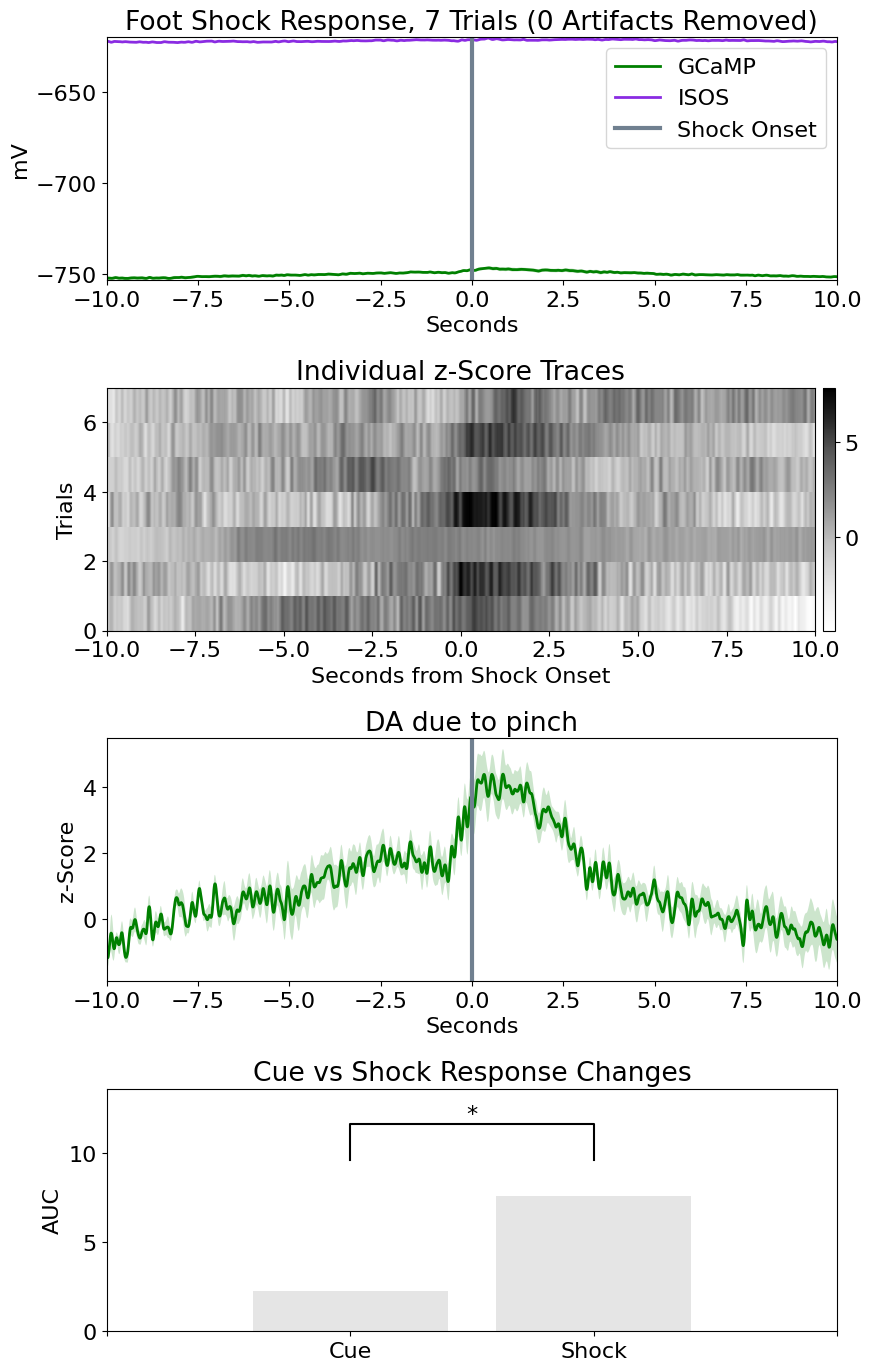

In [87]:
ax3 = fig.add_subplot(414)
p9 = ax3.bar(np.arange(len(AUC)), AUC, color=[.8, .8, .8], align='center', alpha=0.5)

# statistical annotation
x1, x2 = 0, 1 # columns indices for labels
y, h, col = max(AUC) + 2, 2, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
p10 = ax3.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

# Finish up the plot
ax3.set_ylim(0,y+2*h)
ax3.set_ylabel('AUC')
ax3.set_title('Cue vs Shock Response Changes')
ax3.set_xticks(np.arange(-1, len(AUC)+1))
ax3.set_xticklabels(['','Cue','Shock',''])

fig.tight_layout()
fig
